In [2]:
%pip install awswrangler --quiet
from re import sub 
from functools import partial

import boto3
import awswrangler as wr
import pandas as pd
import matplotlib.pyplot as plt

session = boto3.Session() 




[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
fetch = partial(wr.athena.read_sql_query, 
                database='universityose_db', 
                boto3_session=session, 
                s3_output='s3://universityose-bucket/yvlcmb/awswrangler/') # you need to change this output to a directory/S3 bucket you can access

flights_df = fetch(sql="SELECT flightid, COUNT(*) AS rows FROM phase_of_flight WHERE year IN ('2022', '2023') GROUP BY (flightid) ORDER BY rows")

def parse_flightid(in_df): 
    df = in_df.copy()
    df['platform'] = df.flightid.str.slice(0,6)
    df['start'] = df.flightid.str.slice(7,22)
    df['stop'] = df.flightid.str.slice(23)
    df['year'] = df.flightid.str.slice(7,11)
    df['month'] = df.flightid.str.slice(11,13)
    df['day'] = df.flightid.str.slice(13,15)
    df['ymd'] = df.year + df.month + df.day
    return df

columns_and_aliases = {
    "flightid": "flightid", 
    "times_seconds":"seconds",
    "flightstate_position_pitch":"pitch", 
    "flightstate_position_roll":"roll",
    "flightstate_speeds_trueairspeed":"speed", 
    "flightstate_rates_climbordescentrate":"descent"
}


In [4]:
df = parse_flightid(flights_df)
# generate a subset of the list of the flight_ids to query athena with, 
# if you didn't do this step, it would crash the kernel because it would be
# using all the fights from 2022 and 2023
low_g = df[df.ymd.isin(('20230615', '20230615', '20230216', '20230126', '20221020', '20221006'))].flightid.tolist()

In [19]:
columns_and_aliases = {
    "flightid": "flightid", 
    "times_seconds":"seconds",
    "flightstate_position_pitch":"pitch", 
    "flightstate_position_roll":"roll",
    "flightstate_speeds_trueairspeed":"speed", 
    "flightstate_rates_climbordescentrate":"descent",
    "flightstate_altitudes_gpsaltitude":"altitude"
}

def create_sql_from_flightid(flightid, cols=columns_and_aliases):
    contents = flightid.split('_')
    t1, t2 = contents[1:]
    year = t1[:4]
    month = t1[4:6]
    day = t1[6:8]
    ymd = '-'.join((year,month,day))
    hour1 = t1[-6:]
    hour2 = t2[-6:]
    ts1 = ':'.join((hour1[-6:-4], hour1[-4:-2], hour1[-2:]+'.000'))
    ts2 = ':'.join((hour2[-6:-4], hour2[-4:-2], hour2[-2:]+'.000'))
    sql_query = ''.join((
        'SELECT ', 
        *[f'{k} AS {v}, ' for k, v in columns_and_aliases.items()], 
        "FROM flight_details ", 
        f"WHERE year='{year}' ",
        f"AND month='{month}' ",
        f"AND times_gpsdatetime > CAST('{ymd} {ts1}' AS timestamp) ",
        f"AND times_gpsdatetime < CAST('{ymd} {ts2}' AS timestamp)"))
    return sub(', FROM', ' FROM', sql_query)

In [20]:
def calculate_diffs(flightid):
    df = fetch(create_sql_from_flightid(flightid))
    df['vert_accel'] = ( # vertical acceleration
        (df.descent - df.descent.shift(1)) / 
        (df.seconds - df.seconds.shift(1))
    )
    diff_cols = {
        '_'.join((col, 'diff')): df[col].diff() 
        for col in df.columns.to_list()[1:]
    }
    for key, val in diff_cols.items(): 
        df[key] = pd.Series(val)
    return df.dropna() 
        
frames = list(map(calculate_diffs, low_g))

In [53]:
frames[0]

flightid       seconds  pitch     roll  \
2     31dcb8_20230615T132249_20230615T132535  1.686835e+09 -0.651   -0.397   
3     31dcb8_20230615T132249_20230615T132535  1.686835e+09 -0.640   -0.401   
4     31dcb8_20230615T132249_20230615T132535  1.686835e+09 -0.629   -0.406   
5     31dcb8_20230615T132249_20230615T132535  1.686835e+09 -0.616   -0.412   
6     31dcb8_20230615T132249_20230615T132535  1.686835e+09 -0.589   -0.426   
...                                      ...           ...    ...      ...   
6663  31dcb8_20230615T132249_20230615T132535  1.686836e+09 -9.638  119.528   
6664  31dcb8_20230615T132249_20230615T132535  1.686836e+09 -9.638  119.528   
6665  31dcb8_20230615T132249_20230615T132535  1.686836e+09 -9.638  119.529   
6666  31dcb8_20230615T132249_20230615T132535  1.686836e+09 -9.638  119.529   
6667  31dcb8_20230615T132249_20230615T132535  1.686836e+09 -9.638  119.529   

         speed  descent  altitude  vert_accel  seconds_diff  pitch_diff  \
2     0.013627    1.225     57.62    6.333361         0.021       0.007   
3     0.020737    1.343     57.62    6.210509         0.019       0.011   
4     0.029032    1.432     57.61    4.944475         0.018       0.011   
5     0.037326    1.511     57.61    4.647005         0.017       0.013   
6     0.049176    1.613     57.61    3.777785         0.027       0.027   
...        ...      ...       ...         ...           ...         ...   
6663  0.001777    0.069     70.37   -0.090909         0.022       0.000   
6664  0.001777    0.067     70.37   -0.076923         0.026       0.000   
6665  0.001777    0.066     70.37   -0.045455         0.022       0.000   
6666  0.001777    0.064     70.37   -0.099999         0.020       0.000   
6667  0.001777    0.063     70.37   -0.035714         0.028       0.000   

      roll_diff  speed_diff  descent_diff  altitude_diff  vert_accel_diff  
2        -0.001   -0.003555         0.133           0.00         3.106099  
3        -0.004    0.007110         0.118           0.00        -0.122852  
4        -0.005    0.008295         0.089          -0.01        -1.266034  
5        -0.006    0.008295         0.079           0.00        -0.297471  
6        -0.014    0.011850         0.102           0.00        -0.869220  
...         ...         ...           ...            ...              ...  
6663      0.000    0.000000        -0.002           0.00         0.004330  
6664      0.000    0.000000        -0.002           0.00         0.013986  
6665      0.001    0.000000        -0.001           0.00         0.031468  
6666      0.000    0.000000        -0.002           0.00        -0.054544  
6667      0.000    0.000000        -0.001           0.00         0.064284  

[6666 rows x 15 columns]

In [51]:
def normalize(col: pd.Series) -> float:
    """Normalize a column.

    Parameters
    ----------
    col: the column in a dataframe to be normalized

    Returns
    -------
    a float type of the normalized value
    """
    low = col.min()
    rnge = col.max() - low
    return (col - low) / rnge

/opt/conda/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


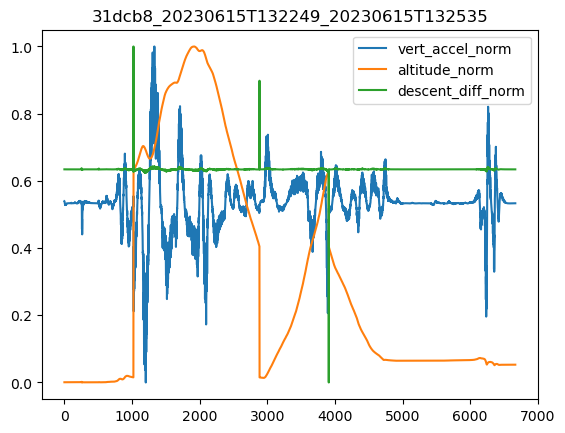

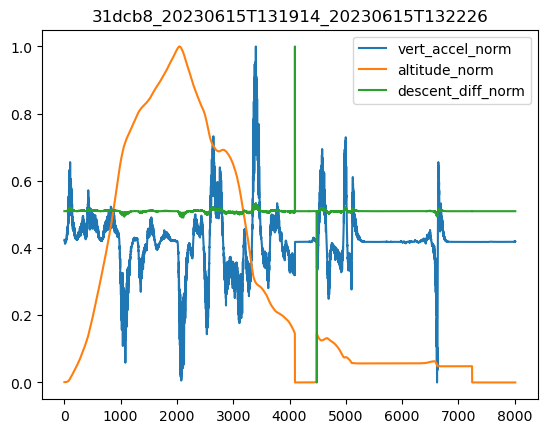

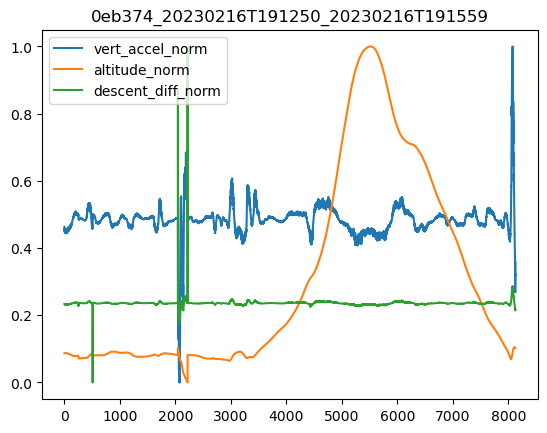

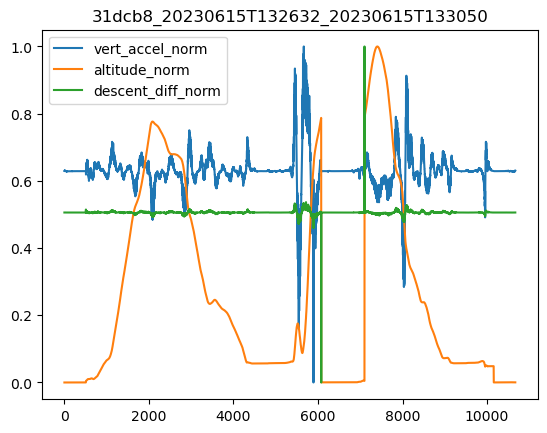

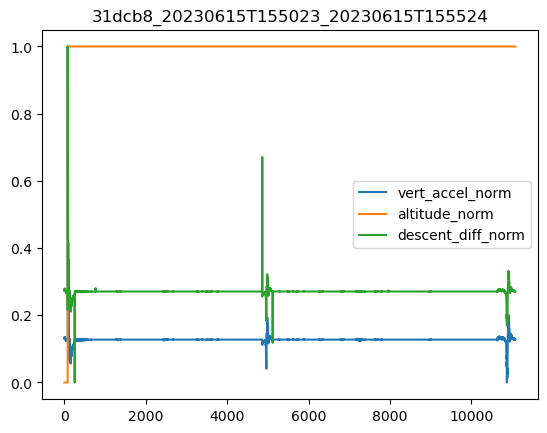

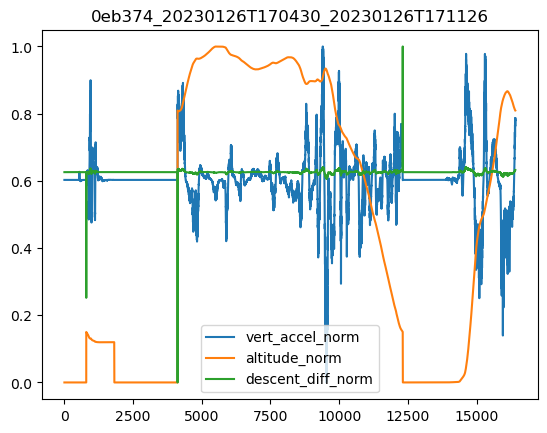

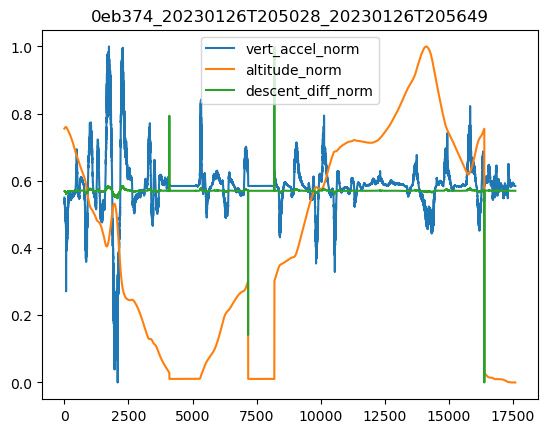

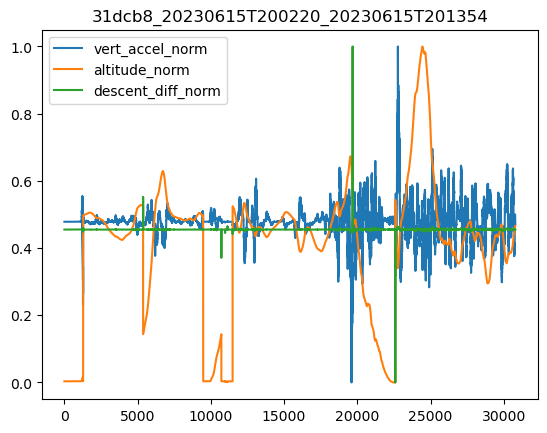

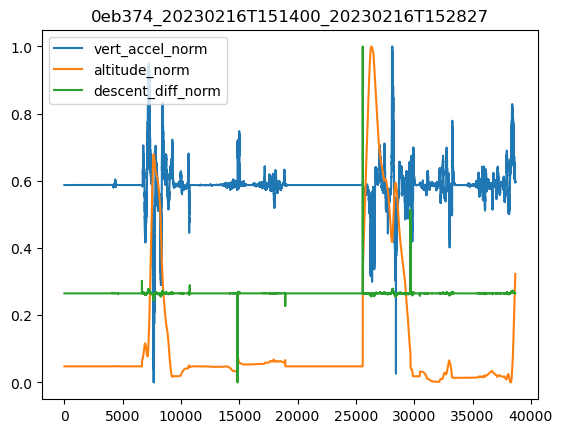

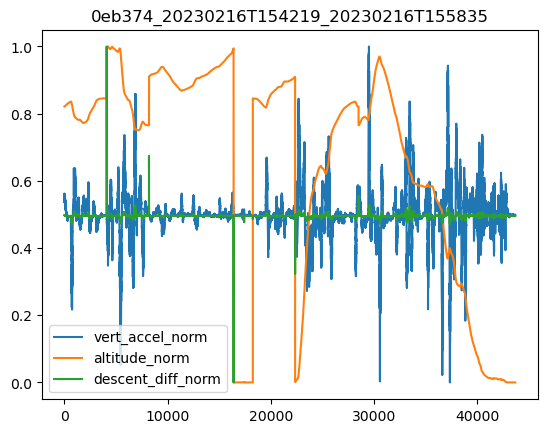

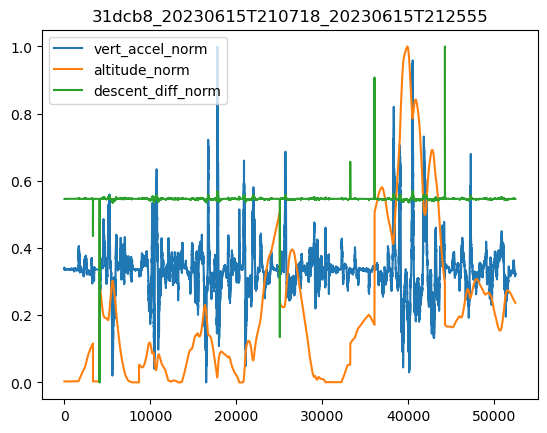

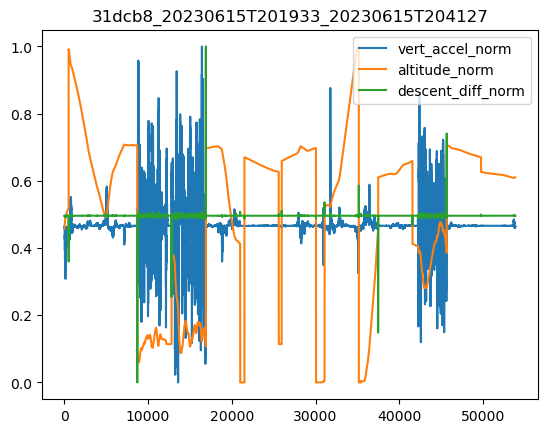

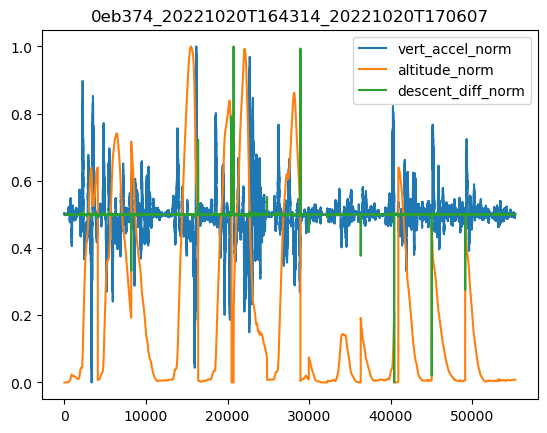

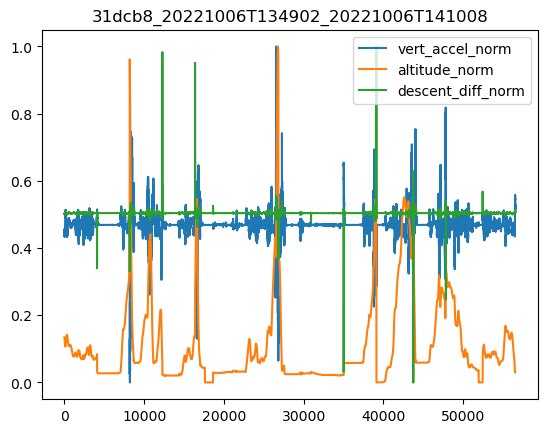

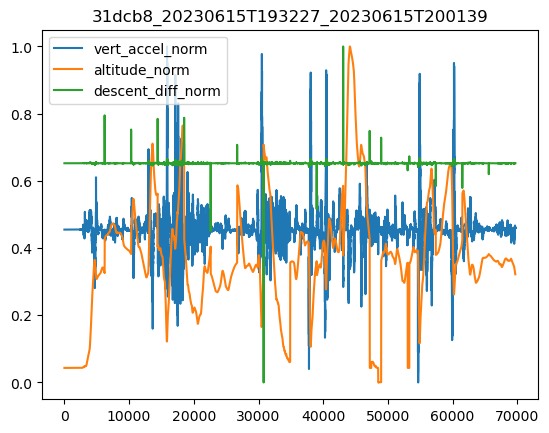

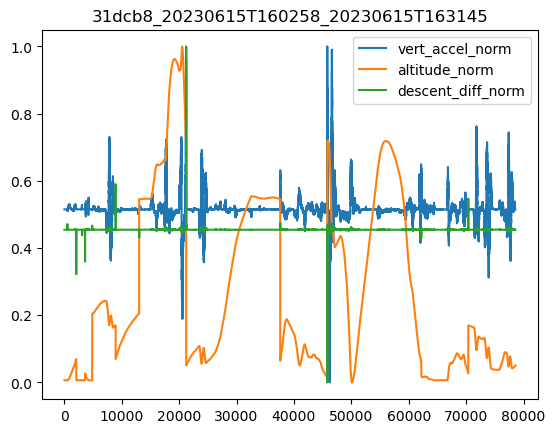

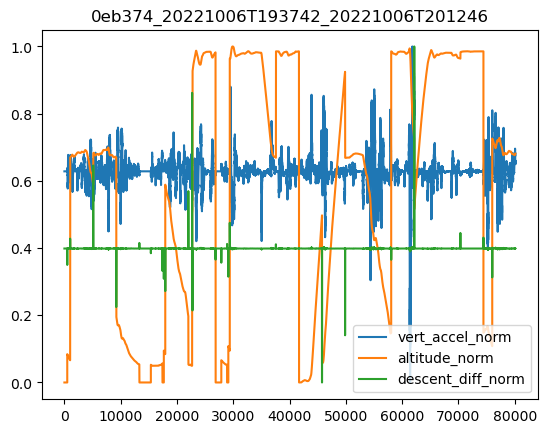

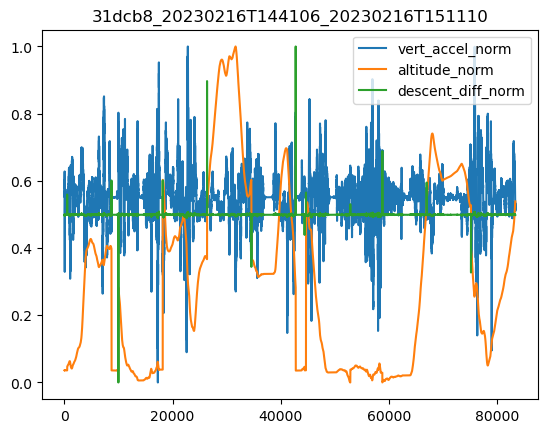

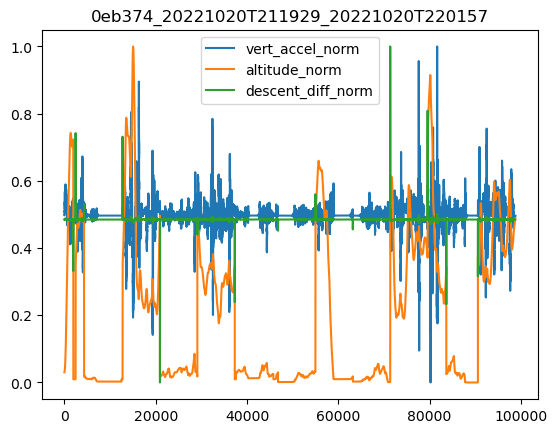

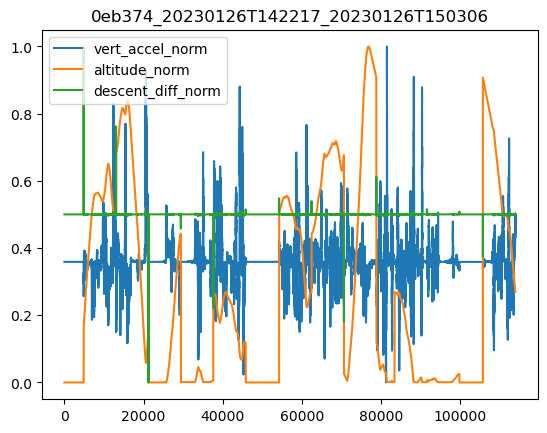

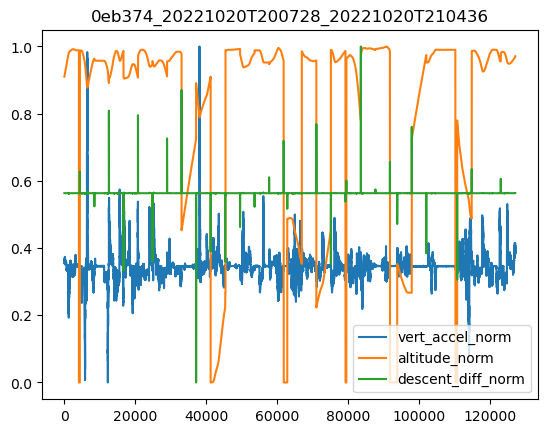

In [54]:
plot_cols = ['vert_accel_norm', 'altitude_norm', 'descent_diff_norm']

for frame in frames:
    normalized = frame[['flightid', 'seconds']].join(
        frame[['vert_accel', 'roll_diff', 'altitude', 'descent_diff']].apply(normalize)
    )
    
    normalized.columns = (
    'flightid', 
    'seconds', 
    'vert_accel_norm', 
    'roll_diff_norm', 
    'altitude_norm', 
    'descent_diff_norm'
    )
    normalized[plot_cols].plot(title=frame.flightid.iloc[0])